In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
workouts = pd.read_csv('workouts.csv', parse_dates=['start_at']) 

users = pd.read_excel('users.xlsx') # подключимся к данным по клиентам

Создадим новый датафрейм, в котором соединены уроки и пользователи

In [3]:
workouts_users =  pd.merge(workouts, 
                           users, 
                           how='left',                      
                           left_on='client_id', 
                           right_on='user_id')

In [4]:
payments = pd.read_excel('payments.xlsx') # подключимся к данным по оплатам

marketing = pd.read_excel('marketing.xlsx') # подключимся к данным маркетинга

____

### Задача

Маркетологи просят помочь запланировать затраты на маркетинг с учётом планов по привлечению клиентов. Можем ли мы ожидать, что если увеличить бюджет на привлечение — количество новых клиентов увеличится пропорционально?

Посмотрим, как коррелируют (соотносятся) затраты на маркетинг с количеством привлеченных клиентов.

Для такого исследования хорошо подходит __scatter plot__.

__Подготовим данные__

1. Берем данные о первых оплатах
2. Объединяем данные о первых оплатах с данными по привлечению
3. Группируем данные первых оплат по месяцам, так как данные маркетинга — ежемесячные

Найдем количество первых оплат по месяцам и по географии

In [5]:
# переводим даты в нужный формат
payments['payment_datetime'] = pd.to_datetime(payments.payment_date) 

# объединим платежи и данные о географии студентов
payments_with_geo = pd.merge(payments, 
                             users[['user_id','geo_group']], 
                             on='user_id') 

In [6]:
# вычисляем даты первых оплат для каждого клиента
fst_payment = payments_with_geo.groupby(['user_id', 'geo_group'])['payment_date'].min() 

# сбрасываем индекс
fst_payment = fst_payment.reset_index() 

# считаем количество первых оплат в каждом месяце и гео-группе
fst_payment_month = fst_payment.groupby([fst_payment['payment_date'].dt.month,
                                         fst_payment['geo_group']])['user_id'].count().reset_index() 

In [7]:
fst_payment_month.head(3)

,payment_date,geo_group,user_id
0,1,Без страны,2
1,1,Москва,194
2,1,Регионы РФ,169


In [8]:
# переименовали с помощью метода .columns

fst_payment_month.columns = ['month', 'geo_group', 'sales'] 

In [9]:
fst_payment_month.head(3)

,month,geo_group,sales
0,1,Без страны,2
1,1,Москва,194
2,1,Регионы РФ,169


Объединим первые оплаты с данными о затратах на маркетинг

In [10]:
marketing_sales = pd.merge(fst_payment_month, 
                           marketing, 
                           on=['geo_group','month'])
marketing_sales.head()

,month,geo_group,sales,budget
0,1,Москва,194,789709.675027
1,1,Регионы РФ,169,372466.203893
2,1,СНГ,58,201283.338968
3,2,Москва,207,931588.682871
4,2,Регионы РФ,208,629203.981110


Найдём общее количество привлеченных клиентов и сумму затрат на маркетинг

In [11]:
marketing_sales_total = marketing_sales.groupby('month')[['sales','budget']].sum().reset_index()

marketing_sales_total.head()

,month,sales,budget
0,1,421,1.363459e+06
1,2,490,1.985795e+06
2,3,488,1.990748e+06
3,4,698,4.308354e+06
4,5,432,1.499338e+06


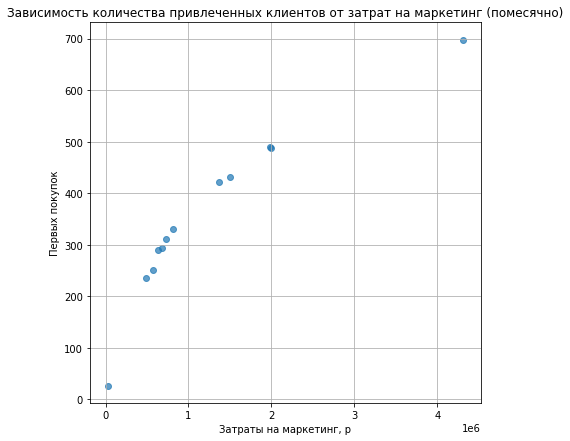

In [12]:
plt.figure(figsize=(7, 7))  



plt.title('Зависимость количества привлеченных клиентов от затрат на маркетинг (помесячно)') 
plt.xlabel('Затраты на маркетинг, р') 
plt.ylabel('Первых покупок') 

plt.grid() 

# передали 3 аргумента
plt.scatter(
        marketing_sales_total['budget'], 
        marketing_sales_total['sales'], 
        alpha = 0.7 
)

plt.show() 

Увеличение бюджета не ведет к пропорциональному росту продаж — они растут заметно медленнее.

### Задача 

Посмотреть, как выглядят наши затраты на маркетинг в разных гео-группах

Для начала посмотрим, какие значения может принимать колонка с гео-группой. Для этого воспользуемся множествами, так как они хранят только уникальные значения. Приведем ко множеству столбец с гео-группами:

In [54]:
set(marketing_sales['geo_group'])

{'Москва', 'Регионы РФ', 'СНГ'}

**Создадим словарь, в котором гео-группы — это ключи, а номера для цветов — их значения.**

In [55]:
# зададим цвет для каждой группы

values = {'Москва':1, 
          'Регионы РФ':2, 
          'СНГ':3} 


In [56]:
marketing_sales['geo_group'].map(values)

0     1
1     2
2     3
3     1
4     2
5     3
6     1
7     2
8     3
9     1
10    2
11    3
12    1
13    2
14    3
15    1
16    2
17    3
18    1
19    2
20    3
21    1
22    2
23    3
24    1
25    2
26    3
27    1
28    2
29    3
30    1
31    2
32    3
33    1
34    2
35    3
Name: geo_group, dtype: int64

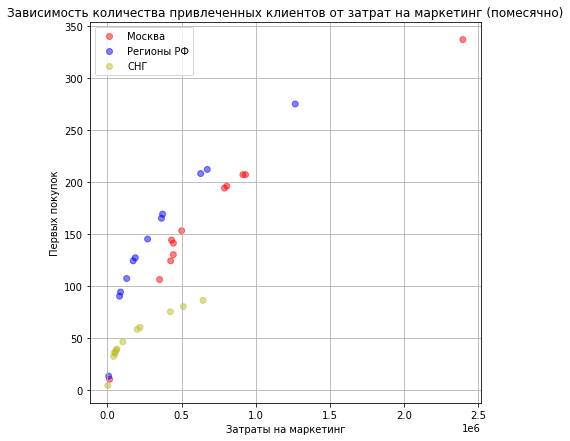

In [59]:
plt.figure(figsize=(7, 7))  # Зададим размер фигуры


plt.title('Зависимость количества привлеченных клиентов от затрат на маркетинг (помесячно)') 
plt.xlabel('Затраты на маркетинг') 
plt.ylabel('Первых покупок') 
plt.grid() # сетка

scatter = plt.scatter(
    marketing_sales.budget, # ось OX 
    marketing_sales.sales, # ось OY
    
    c = marketing_sales['geo_group'].map(values),  
    cmap = ListedColormap(['r', 'blue', 'tab:olive']),
    alpha = 0.5 # Прозрачность 50%
)
plt.legend(handles=scatter.legend_elements()[0], labels=['Москва', 'Регионы РФ', 'СНГ'])


Чтобы скорректировать диапазон значений на оси Х, изменим масштаб осей с помощью функций `xlim()`, `ylim()` — они задают начальное и конечное значение по каждой оси. 

Сделаем так, чтобы ось `X` начиналась с -10 тыс. и заканчивалась 1 млн.рублей, а на оси `Y` (количество привлеченных клиентов) значения были от 0 до 250.
Это нужно в двух случаях:

* чтобы убрать выбросы
* чтобы скорректировать положение диаграммы и сделать её более удобной для анализа

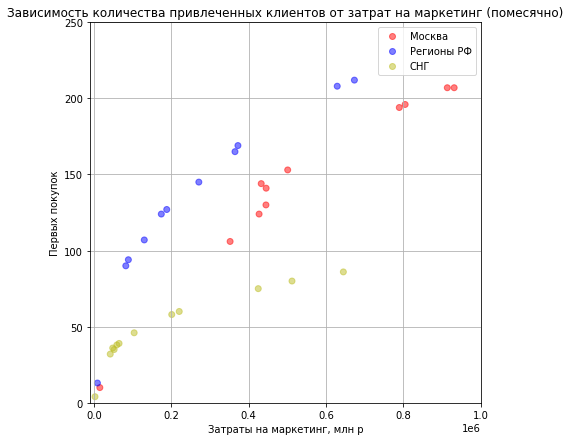

In [60]:
plt.figure(figsize=(7, 7))  # зададим размер фигуры

# зададим масштаб осей
plt.xlim(-10_000, 1_000_000) # минусовое значение, чтобы не отрезать 0
plt.ylim(0, 250)

plt.title('Зависимость количества привлеченных клиентов от затрат на маркетинг (помесячно)') 
plt.xlabel('Затраты на маркетинг, млн р') 
plt.ylabel('Первых покупок') 

plt.grid() # сетка

scatter = plt.scatter(
    marketing_sales.budget, # ось X 
    marketing_sales.sales, # ось Y
    c = marketing_sales['geo_group'].map(values),  
    cmap = ListedColormap(['r', 'blue', 'tab:olive']),
    alpha = 0.5 # прозрачность 50%
)
plt.legend(handles=scatter.legend_elements()[0], labels=['Москва', 'Регионы РФ', 'СНГ'])

